# **Data Wrangling - Google Analytics Customer Revenue Prediction**

[Import libraries and other setup](#section1)

[Load data and flatten json blobs](#section2)

[Data at first glance - size and metadata](#section3)

[Delete non useful columns](#section4)

[Fill up missing values](#section5)
- [Columns having single value other than nulls](#section6)
- [Columns having multiple values other than nulls](#section7)

[Check validity of Geo columns](#section8)
- [Add more subsections here](#section6)

[Save the cleaned data to csv](#section9)

<a id='section1'></a>

In [246]:
# import the necessary libraries
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import defaultdict

# setup 
#sns.set_style(style="whitegrid")
sns.set_style('ticks')

# display charts inline
%matplotlib inline

# to display all columns
pd.set_option('display.max_columns', None)


<a id='section2'></a>

### Load the data and flatten the json fields

In [247]:
# json_normalize doesn't work in google cloud/colab env. for all json columns. 
# df[column].apply(pd.Series) could be used instead.

def load_df(csv_path='../data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    return df

In [249]:
%%time
# load the data, test data is only for the submission to kaggle
train_df = load_df()

#  load at the time of final reporting
#test_df = load_df("test.csv")

Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 22s, sys: 14.2 s, total: 2min 36s
Wall time: 2min 37s


##### Checkpoint - Before moving ahead we should keep a copy of original train_df

In [250]:
# original data saved
original_train_df = train_df.copy()

<a id='section3'></a>

### First look at data, its size and metadata

In [ ]:
# checkout few rows and all the columns data
train_df.head()

In [ ]:
# metadata, total rows: 903653, total columns: 55
train_df.info()

In [254]:
# metadata - number of unique values and null values for each column
info = pd.DataFrame(index=train_df.columns.values,data={'data type': train_df.dtypes, \
                          'unique values': train_df.nunique(), 'null values': train_df.isnull().sum()})

In [255]:
info.sort_values(['unique values','null values'])

,data type,unique values,null values
socialEngagementType,object,1,0
device.browserSize,object,1,0
device.browserVersion,object,1,0
device.flashVersion,object,1,0
device.language,object,1,0
device.mobileDeviceBranding,object,1,0
device.mobileDeviceInfo,object,1,0
device.mobileDeviceMarketingName,object,1,0
device.mobileDeviceModel,object,1,0
device.mobileInputSelector,object,1,0


<a id='section4'></a>

### Delete non useful columns

In [265]:
# Columns with 1 unique value and zero null value might not be useful
# let us check those columns

def single_valued_columns(df, meta_info):
    single_valued_columns = []
    for col in meta_info[(meta_info['unique values']==1) & (meta_info['null values'] ==0)].index:
        unique_value = df[col].unique()
        print(col, unique_value)
        single_valued_columns.append(col)
    return single_valued_columns

In [267]:
# these columns can be deleted - columns names ['unique-value']
cols_to_delete = single_valued_columns(train_df, info)

socialEngagementType ['Not Socially Engaged']
device.browserSize ['not available in demo dataset']
device.browserVersion ['not available in demo dataset']
device.flashVersion ['not available in demo dataset']
device.language ['not available in demo dataset']
device.mobileDeviceBranding ['not available in demo dataset']
device.mobileDeviceInfo ['not available in demo dataset']
device.mobileDeviceMarketingName ['not available in demo dataset']
device.mobileDeviceModel ['not available in demo dataset']
device.mobileInputSelector ['not available in demo dataset']
device.operatingSystemVersion ['not available in demo dataset']
device.screenColors ['not available in demo dataset']
device.screenResolution ['not available in demo dataset']
geoNetwork.cityId ['not available in demo dataset']
geoNetwork.latitude ['not available in demo dataset']
geoNetwork.longitude ['not available in demo dataset']
geoNetwork.networkLocation ['not available in demo dataset']
totals.visits ['1']
trafficSource.ad

In [269]:
# drop the columns above
for col in cols_to_delete:
    train_df.drop(col, inplace=True, axis=1)

In [270]:
# what's the new shape of train data after deleting columns
train_df.shape

(903653, 36)

##### Checkpoint - After deleting columns

In [271]:
# save into checkpoint one
checkpoint_1_df = train_df.copy()

<a id='section5'></a>

### Fill up missing values

<a id='section6'></a>

#### Columns having single value other than nulls

In [298]:
# single valued columns but having nulls
for col in info[(info['unique values']==1) & (info['null values'] > 0)].index:
    print(col, train_df[col].unique())

totals.bounces ['1' nan]
totals.newVisits ['1' nan]
trafficSource.adwordsClickInfo.isVideoAd [nan False]
trafficSource.campaignCode [nan '11251kjhkvahf']
trafficSource.isTrueDirect [nan True]


In [297]:
# change boolean variables into 1/0 number
def boolean_to_one_zero(col, value, bool_value):
    if bool_value:
        train_df.loc[train_df[col] == value, col] = 1
        train_df[col].fillna(0,inplace=True)
    else:
        train_df.loc[train_df[col] == value, col] = 0
        train_df[col].fillna(1,inplace=True)
    train_df[col] = train_df[col].astype(int)

In [299]:
# convert nans to either 0 or 1
boolean_to_one_zero('totals.bounces',1,True)
boolean_to_one_zero('totals.newVisits',1,True)
boolean_to_one_zero('trafficSource.adwordsClickInfo.isVideoAd',False,False)
boolean_to_one_zero('trafficSource.campaignCode','11251kjhkvahf',False)
boolean_to_one_zero('trafficSource.isTrueDirect',True,True)

In [310]:
# verify changed columns
for col in info[(info['unique values']>1) & (info['null values'] > 0)].index:
    print(col, len(train_df[col].unique()))

totals.pageviews 214
totals.transactionRevenue 5333
trafficSource.adContent 45
trafficSource.adwordsClickInfo.adNetworkType 3
trafficSource.adwordsClickInfo.gclId 17775
trafficSource.adwordsClickInfo.page 9
trafficSource.adwordsClickInfo.slot 3
trafficSource.keyword 3660
trafficSource.referralPath 1476


In [301]:
# save into checkpoint two
checkpoint_2_df = train_df.copy()
checkpoint_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 36 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                       

In [311]:
train_df.head(10)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,1,(not provided),organic,NaN,google
5,Organic Search,20160902,2938943183656635653,2938943183656635653_1472807194,1472807194,1,1472807194,Chrome,desktop,False,Windows,not available in demo dataset,Europe,Italy,not available in demo dataset,fastwebnet.it,not available in demo dataset,Southern Europe,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
6,Organic Search,20160902,1905672039242460897,1905672039242460897_1472817241,1472817241,1,1472817241,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Pakistan,not available in demo dataset,unknown.unknown,not available in demo dataset,Southern Asia,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
7,Organic Search,20160902,537222803633850821,537222803633850821_1472812602,1472812602,1,1472812602,Chrome,desktop,False,Windows,Brisbane,Oceania,Australia,(not set),bigpond.net.au,Queensland,Australasia,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
8,Organic Search,20160902,4445454811831400414,4445454811831400414_1472805784,1472805784,1,1472805784,Internet Explorer,desktop,False,Windows,not available in demo dataset,Europe,Austria,not available in demo dataset,spar.at,not available in demo dataset,Western Europe,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,(not set),1,0,(not provided),organic,NaN,google
9,Organic Search,20160902,9499785259412240342,9499785259412240342_1472812272,1472812272,1,1472812272,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Netherlands,not available in demo dataset,chello.nl,not available in demo dataset,Western Europe,1,1,1,1,NaN,NaN,NaN,NaN,1

<a id='section7'></a>

#### Columns having more than one value other than nulls 
**pageviews, transactionRevenue, adContent, adNetworkType, gclId, page, slot, keyword, referralPath**

In [326]:
# multi valued columns and having nulls
# categorical columns here would have to be one hot encoded later on or binned in some way
for col in info[(info['unique values']>1) & (info['null values'] > 0)].index:
    print(col, train_df[col].nunique(), train_df[col].isnull().sum())

totals.pageviews 213 100
totals.transactionRevenue 5332 892138
trafficSource.adContent 44 892707
trafficSource.adwordsClickInfo.adNetworkType 2 882193
trafficSource.adwordsClickInfo.gclId 17774 882092
trafficSource.adwordsClickInfo.page 8 882193
trafficSource.adwordsClickInfo.slot 2 882193
trafficSource.keyword 3659 502929
trafficSource.referralPath 1475 572712


##### totals.pageviews

In [331]:
# let us check unique values for these columns and make them numerical if necessary and fill the nulls
train_df['totals.pageviews'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  20,  19,  21,  25,  22,  26,  23,  24,
        30,  27,  29,  28,  32,  31,  34,  33,  38,  35,  40,  36,  37,
        39,  43,  45,  47,  52,  44,  50,  46,  49,  51,  56,  59,  71,
        57,  82,  84,  92,  90,  41,  79, 138,  48,  69, 112,  42,  65,
        60,  63,  68,  58,  74, 165,  53,  54,  55,  61,  70,  80,  78,
        72, 188,  73,  62,  75,  86, 197, 148,  67, 102,  64, 103, 144,
         0,  81, 119, 104, 128,  87, 111,  66,  83, 135,  94,  91,  99,
        77, 118, 202, 127,  93, 106, 155, 117,  76,  89,  85, 143, 105,
       115,  95, 110, 137, 120, 116, 208, 126, 400, 101, 108, 333,  97,
        96,  98, 125, 113, 327, 154, 121, 183, 123, 141, 224,  88, 195,
       343, 156, 193, 100, 150, 122, 145, 174, 147, 131, 169, 164, 249,
       114, 189, 223, 124, 139, 341, 469, 309, 162, 146, 270, 107, 153,
       233, 161, 179, 129, 220, 191, 323, 431, 351, 132, 305, 17

In [330]:
# fillna and make it int
train_df['totals.pageviews'].fillna(0, inplace=True)
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype(int)

##### totals.transactionRevenue

In [335]:
# transaction revenue
train_df['totals.transactionRevenue'].describe()

count    9.036530e+05
mean     1.704273e+06
std      5.277866e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [334]:
# fillna and make it int
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)

##### trafficSource.adContent

In [338]:
# trafficSource.adContent
train_df['trafficSource.adContent'].unique()

array(['Others', 'Full auto ad IMAGE ONLY',
       'First Full Auto Template Test Ad', '{KeyWord:Google Brand Items}',
       'Display Ad created 3/11/14', 'Ad from 11/7/16',
       'Display Ad created 3/11/15', 'Ad from 12/13/16',
       'Ad from 11/3/16', 'Google Online Store',
       'Google Merchandise Collection', '{KeyWord:Want Google Stickers?}',
       '{KeyWord:Google Merchandise}', 'Display Ad created 11/17/14',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Google Paraphernalia',
       'Swag with Google Logos', '{KeyWord:Google Branded Kit}',
       'Want Google Sunglasses', '{KeyWord:Looking for Google Bags?}',
       'Full auto ad TEXT ONLY', 'Google Merchandise', 'google store',
       'LeEco_1a', 'Full auto ad TEXT/NATIVE',
       '{KeyWord:Want Google Pet Toys?}', 'Google Store',
       "Men's-Outerwear Google Apparel", '20% discount',
       'Full auto ad with 

In [337]:
# fillna with string 'Others'
train_df['trafficSource.adContent'].fillna('Others', inplace=True)

In [341]:
# add to less_important_cols becuase very few non null as compared to nulls
less_important_cols = []
less_important_cols.append('trafficSource.adContent')

##### trafficSource.adwordsClickInfo.adNetworkType

In [339]:
# trafficSource.adwordsClickInfo.adNetworkType
# this column may be unimportant because it has huge number of nulls, revisit it later
train_df['trafficSource.adwordsClickInfo.adNetworkType'].unique()

array([nan, 'Google Search', 'Search partners'], dtype=object)

In [357]:
# fillna with string 'Unknown'
train_df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('Unknown', inplace=True)

In [342]:
less_important_cols.append('trafficSource.adwordsClickInfo.adNetworkType')

##### trafficSource.adwordsClickInfo.gclId

In [348]:
# trafficSource.adwordsClickInfo.gclId
train_df['trafficSource.adwordsClickInfo.gclId'].unique()[0:10]

array([nan,
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFawcmsrhs02pjO7FXPLhzHyvJFv53h1H4QJ8aAhtw8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRAq0D2zir1iAiqwgFU0lcMGVY6qaqhBTOFSAIW7gM8saAiku8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRMbhgNCALey5pPeCxitqlWsaKLtXW_EC8qRLRreq6OMaApJJ8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBRI7rtb79aCyB-UUNNHh1V712wows-T-MlL9VW-8ZEaAhqd8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRDKcQOTkfRji3NxEErk_rDSPqc8VzHFSZnRcZBCoBOgaAgeG8P8HAQ',
       'Cj0KEQjwo5--BRCS8ceLjv-XppUBEiQAGp15EMNOO9ncAazJnlNvFKMxdy_qTVRlM2NGSXHD4fxc4XkaAlju8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRN5NYAKlTApE4VcfCkTQuPBlp8ja9VqaQ25d6v7ZTCIaApGa8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRLpO3WGRAW4WgE838XKwZhc6aHwQ1Imn5c5rRfuDS4UaAt2t8P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXROwIDheo-LdfHu-wza2rXi7SSZV3OMobMySurMzgb-kaAuyZ8P8HAQ'],
      dtype=object)

In [349]:
# fillna with string 'Unknown'
train_df['trafficSource.adwordsClickInfo.gclId'].fillna('Unknown', inplace=True)
less_important_cols.append('trafficSource.adwordsClickInfo.gclId')

##### trafficSource.adwordsClickInfo.page

In [354]:
# trafficSource.adwordsClickInfo.page
# fillna and make it int
train_df['trafficSource.adwordsClickInfo.page'].fillna(0, inplace=True)
train_df['trafficSource.adwordsClickInfo.page'] = train_df['trafficSource.adwordsClickInfo.page'].astype(int)

##### trafficSource.adwordsClickInfo.slot, trafficSource.keyword, trafficSource.referralPath

In [353]:
# trafficSource.adwordsClickInfo.slot, trafficSource.keyword,trafficSource.referralPath

more_cols = ['trafficSource.adwordsClickInfo.slot',\
            'trafficSource.keyword','trafficSource.referralPath']
for col in more_cols:
    print(train_df[col].unique()[0:10])
    train_df[col].fillna('Unknown', inplace=True)
    less_important_cols.append(col)

[nan 'Top' 'RHS']
['(not provided)' 'google + online' nan 'www google store' 'Google store'
 '6qEhsCssdK0z36ri' 'buy google souvenirs' 'shop shirts' 'google t shirt'
 'google t-shirt']
[nan '/' '/corp/google.com/study/incentives/working-with-perks'
 '/od/Things-To-Do-in-Silicon-Valley/fl/How-To-Visit-the-Googleplex-the-Google-Head-Office-in-Mountain-View.htm'
 '/a/google.com/google-merchandise-store/on-site-store' '/analytics/web/'
 '/intl/en/permissions/using-the-logo.html'
 '/permissions/using-the-logo.html' '/YKEI_mrn/items/c10b14f9a69ff71b1b7a'
 '/analytics/web/inpage_launch']


##### Checkpoint - After filling up missing values

In [359]:
# checkpoint 3
checkpoint_3_df = train_df.copy()

In [358]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 36 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                       

In [360]:
checkpoint_3_df.to_csv('../data/cleaned_train.csv')

In [361]:
checkpoint_3_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google


<a id='section8'></a>

### Check validity of Geo columns

In [382]:
# all geo columns
geo_cols = ['geoNetwork.city','geoNetwork.metro','geoNetwork.region','geoNetwork.country', \
            'geoNetwork.subContinent','geoNetwork.continent']

In [439]:
# how many unique geo combinations
geo_df = train_df[geo_cols].drop_duplicates()
geo_df

,geoNetwork.city,geoNetwork.metro,geoNetwork.region,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent
0,Izmir,(not set),Izmir,Turkey,Western Asia,Asia
1,not available in demo dataset,not available in demo dataset,not available in demo dataset,Australia,Australasia,Oceania
2,Madrid,(not set),Community of Madrid,Spain,Southern Europe,Europe
3,not available in demo dataset,not available in demo dataset,not available in demo dataset,Indonesia,Southeast Asia,Asia
4,not available in demo dataset,not available in demo dataset,not available in demo dataset,United Kingdom,Northern Europe,Europe
5,not available in demo dataset,not available in demo dataset,not available in demo dataset,Italy,Southern Europe,Europe
6,not available in demo dataset,not available in demo dataset,not available in demo dataset,Pakistan,Southern Asia,Asia
7,Brisbane,(not set),Queensland,Australia,Australasia,Oceania
8,not available in demo dataset,not available in demo dataset,not available in demo dataset,Austria,Western Europe,Europe
9,not available in demo dataset,not available in demo dataset,not available in demo dataset,Netherlands,Western Europe,Europe


<div class="alert-success">&nbsp;</div>
We got 1580 unique geo (city, metro, region, country, subcontinent and continent) combinations. They also include values "(not set)" and "not available in demo dataset".
<div class="alert-success">&nbsp;</div>

In [380]:
train_df[geo_cols].nunique()

geoNetwork.city            649
geoNetwork.region          376
geoNetwork.country         222
geoNetwork.subContinent     23
geoNetwork.continent         6
geoNetwork.metro            94
dtype: int64

In [546]:
geo_df.sort_values(['geoNetwork.city','geoNetwork.metro','geoNetwork.region','geoNetwork.country'])

,geoNetwork.city,geoNetwork.metro,geoNetwork.region,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent
119825,'s Hertogenbosch,(not set),North Brabant,Netherlands,Western Europe,Europe
310,(not set),(not set),(not set),(not set),(not set),(not set)
81711,(not set),(not set),(not set),Afghanistan,Southern Asia,Asia
27606,(not set),(not set),(not set),Albania,Southern Europe,Europe
593,(not set),(not set),(not set),Algeria,Northern Africa,Africa
395136,(not set),(not set),(not set),American Samoa,Polynesia,Oceania
148184,(not set),(not set),(not set),Andorra,Southern Europe,Europe
52935,(not set),(not set),(not set),Angola,Middle Africa,Africa
433234,(not set),(not set),(not set),Anguilla,Caribbean,Americas
13196,(not set),(not set),(not set),Armenia,Western Asia,Asia


In [549]:
# drop all not set or not available
geo_df_clean = geo_df.drop(geo_df[(geo_df['geoNetwork.city'] == geo_df['geoNetwork.metro']) \
                                  & (geo_df['geoNetwork.region'] == geo_df['geoNetwork.metro'])].index)

In [551]:
geo_df_clean.sort_values(['geoNetwork.city','geoNetwork.metro','geoNetwork.region','geoNetwork.country'])

,geoNetwork.city,geoNetwork.metro,geoNetwork.region,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent
119825,'s Hertogenbosch,(not set),North Brabant,Netherlands,Western Europe,Europe
205478,(not set),(not set),Algiers Province,Algeria,Northern Africa,Africa
47290,(not set),(not set),Amman Governorate,Jordan,Western Asia,Asia
25507,(not set),(not set),Bac Giang,Vietnam,Southeast Asia,Asia
25595,(not set),(not set),Bac Ninh Province,Vietnam,Southeast Asia,Asia
143845,(not set),(not set),Binh Phuoc,Vietnam,Southeast Asia,Asia
807551,(not set),(not set),Catalonia,Spain,Southern Europe,Europe
18837,(not set),(not set),Chiang Mai,Thailand,Southeast Asia,Asia
153355,(not set),(not set),Chiang Rai,Thailand,Southeast Asia,Asia
17739,(not set),(not set),Chon Buri,Thailand,Southeast Asia,Asia


In [657]:
# what are the number of rows in data set for each unique combination
unique_geo_counts = train_df.groupby(geo_cols).count()

In [662]:
unique_geo_counts = unique_geo_counts.iloc[:,0:1].reset_index().sort_values('channelGrouping').rename(columns={'channelGrouping':'counts'})
unique_geo_counts

,geoNetwork.city,geoNetwork.metro,geoNetwork.region,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent,counts
863,Nairobi,(not set),(not set),(not set),(not set),(not set),1
340,Bogota,(not set),Bogota,El Salvador,Central America,Americas,1
815,Mountain View,San Francisco-Oakland-San Jose CA,California,Dominican Republic,Caribbean,Americas,1
818,Mountain View,San Francisco-Oakland-San Jose CA,California,Guam,Micronesian Region,Oceania,1
331,Berlin,(not set),Berlin,Switzerland,Western Europe,Europe,1
329,Berlin,(not set),Berlin,Finland,Northern Europe,Europe,1
328,Berlin,(not set),Berlin,Austria,Western Europe,Europe,1
823,Mountain View,San Francisco-Oakland-San Jose CA,California,Israel,Western Asia,Asia,1
324,Bengaluru,(not set),Karnataka,Taiwan,Eastern Asia,Asia,1
341,Bogota,(not set),Bogota,Spain,Southern Europe,Europe,1


<div class="alert-success">&nbsp;</div>
On quick check we can easily see that most of the rows with counts of ones have inconsistent values for city, region, country etc. It would make sense to delete these rows after some more verification. Also the number of such rows is not very high in comparision to the amount of data we have and would not affect much while finding the optimum machine learning models.
<div class="alert-success">&nbsp;</div>

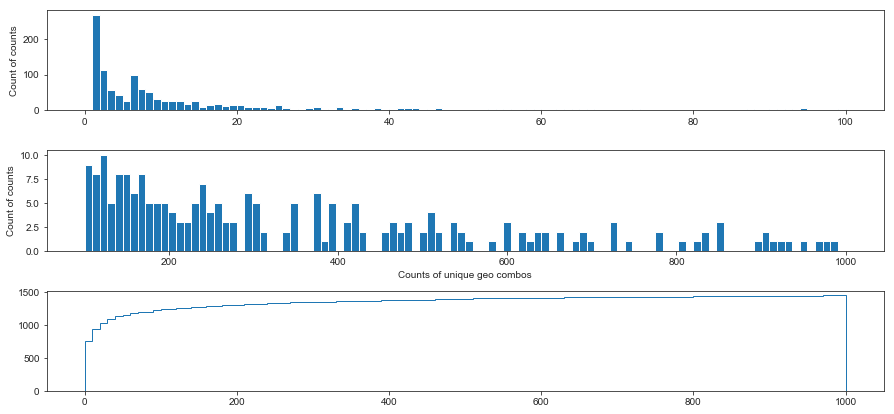

In [699]:
# checkout histogram and cumulative freq plots for counts
fig, ax = plt.subplots(3)
plt.subplots_adjust(hspace = 0.4)
fig.set_size_inches(w=15,h=7)

ax[1].set_xlabel("Counts of unique geo combos")
ax[0].set_ylabel("Count of counts")
ax[1].set_ylabel("Count of counts")

_ = ax[0].hist(unique_geo_counts.counts,bins=100, range=(0,100))
_ = ax[1].hist(unique_geo_counts.counts,bins=100, range=(100,1000))
_ = ax[2].hist(unique_geo_counts.counts,bins=100,cumulative=True,histtype='step',range=(0,1000))


<div class="alert-success">&nbsp;</div>
As can be seen from above hist and cumulative freq plots, the geo combos with count one are around 250 and counts of twos are around 100. But all other counts are quite less in number. This gives an indication that we should at least see the geo combos with counts one. Other geo combos occur frequently in our data. And we dont have a direct way to verify them.
<div class="alert-success">&nbsp;</div>

### Let us check unique values for each column

In [383]:
train_df['geoNetwork.continent'].unique()

array(['Asia', 'Oceania', 'Europe', 'Americas', 'Africa', '(not set)'],
      dtype=object)

In [384]:
train_df['geoNetwork.subContinent'].unique()

array(['Western Asia', 'Australasia', 'Southern Europe', 'Southeast Asia',
       'Northern Europe', 'Southern Asia', 'Western Europe',
       'South America', 'Eastern Asia', 'Eastern Europe',
       'Northern America', 'Western Africa', 'Central America',
       'Eastern Africa', '(not set)', 'Caribbean', 'Southern Africa',
       'Northern Africa', 'Central Asia', 'Middle Africa', 'Melanesia',
       'Micronesian Region', 'Polynesia'], dtype=object)

In [387]:
# here is all looks good not set values can't be filled up yet
train_df[['geoNetwork.subContinent','geoNetwork.continent']].drop_duplicates()

,geoNetwork.subContinent,geoNetwork.continent
0,Western Asia,Asia
1,Australasia,Oceania
2,Southern Europe,Europe
3,Southeast Asia,Asia
4,Northern Europe,Europe
6,Southern Asia,Asia
8,Western Europe,Europe
14,South America,Americas
15,Eastern Asia,Asia
20,Eastern Europe,Europe


<div class="alert-success">&nbsp;</div>
Manual inspection of continent subcontinent shows no invalid data.
<div class="alert-success">&nbsp;</div>

In [389]:
train_df['geoNetwork.country'].unique()

array(['Turkey', 'Australia', 'Spain', 'Indonesia', 'United Kingdom',
       'Italy', 'Pakistan', 'Austria', 'Netherlands', 'India', 'France',
       'Brazil', 'China', 'Singapore', 'Argentina', 'Poland', 'Germany',
       'Canada', 'Thailand', 'Hungary', 'Malaysia', 'Denmark', 'Taiwan',
       'Russia', 'Nigeria', 'Belgium', 'South Korea', 'Chile', 'Ireland',
       'Philippines', 'Greece', 'Mexico', 'Montenegro', 'United States',
       'Bangladesh', 'Japan', 'Slovenia', 'Czechia', 'Sweden',
       'United Arab Emirates', 'Switzerland', 'Portugal', 'Peru',
       'Hong Kong', 'Vietnam', 'Sri Lanka', 'Serbia', 'Norway', 'Romania',
       'Kenya', 'Ukraine', 'Israel', 'Slovakia', '(not set)', 'Lithuania',
       'Puerto Rico', 'Bosnia & Herzegovina', 'Croatia', 'South Africa',
       'Paraguay', 'Botswana', 'Colombia', 'Uruguay', 'Algeria',
       'Finland', 'Guatemala', 'Egypt', 'Malta', 'Bulgaria',
       'New Zealand', 'Kuwait', 'Uzbekistan', 'Saudi Arabia', 'Cyprus',
       'Estoni

In [390]:
geo_major_df = train_df[['geoNetwork.country','geoNetwork.subContinent','geoNetwork.continent']].drop_duplicates()

In [661]:
geo_major_df

,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent
0,Turkey,Western Asia,Asia
1,Australia,Australasia,Oceania
2,Spain,Southern Europe,Europe
3,Indonesia,Southeast Asia,Asia
4,United Kingdom,Northern Europe,Europe
5,Italy,Southern Europe,Europe
6,Pakistan,Southern Asia,Asia
8,Austria,Western Europe,Europe
9,Netherlands,Western Europe,Europe
10,India,Southern Asia,Asia


In [398]:
geo_major_df[geo_major_df['geoNetwork.continent'] == '(not set)']

,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent
310,(not set),(not set),(not set)


<div class="alert-success">&nbsp;</div>
The number of unique (country, subContinent, continent) is 222, same as the number of unique countries. So we have no conflicts here. And all data is good. Now we can proceed to check what the discrepancies at city or smaller scale.
<div class="alert-success">&nbsp;</div>

In [400]:
geo_minor_df =  train_df[['geoNetwork.city','geoNetwork.metro','geoNetwork.region']].drop_duplicates()

In [402]:
geo_minor_df['geoNetwork.region'].unique()

array(['Izmir', 'not available in demo dataset', 'Community of Madrid',
       'Queensland', 'Sindh', 'Ile-de-France', '(not set)',
       'Buenos Aires', 'Bangkok', 'Jakarta', 'Karnataka', 'England',
       'North Holland', 'Moscow', 'West Bengal', 'Seoul',
       'Santiago Metropolitan Region', 'Masovian Voivodeship',
       'Dublin City', 'Mexico City', 'Catalonia', 'State of Sao Paulo',
       'California', 'Istanbul', 'Dubai', 'Delhi', 'New South Wales',
       'New York', 'State of Rio de Janeiro', 'Telangana', 'Ontario',
       'District of Columbia', 'Maharashtra', 'Washington', 'Lazio',
       'Illinois', 'Massachusetts', 'Tel Aviv District', 'Lima Region',
       'Michigan', 'Taipei City', 'Texas', 'Pennsylvania', 'Quebec',
       'Virginia', 'Ho Chi Minh', 'Hanoi', 'Nuevo Leon', 'Ankara',
       'Metro Manila', 'Budapest', 'Tokyo', 'British Columbia',
       'Kanagawa Prefecture', 'County Dublin', 'Stockholm County',
       'Oregon', 'Colorado', 'Bavaria', 'Tamil Nadu', 'Kyi

In [403]:
geo_minor_df['geoNetwork.metro'].unique()

array(['(not set)', 'not available in demo dataset', 'London',
       'San Francisco-Oakland-San Jose CA', 'New York NY',
       'Washington DC (Hagerstown MD)', 'Los Angeles CA',
       'Seattle-Tacoma WA', 'Chicago IL', 'Boston MA-Manchester NH',
       'Detroit MI', 'Austin TX', 'Pittsburgh PA', 'Roanoke-Lynchburg VA',
       'Dallas-Ft. Worth TX', 'Portland OR', 'Denver CO', 'Houston TX',
       'Atlanta GA', 'San Diego CA', 'Phoenix AZ', 'Columbus OH',
       'Charlotte NC', 'Jacksonville FL',
       'Meridian (exc. Channel Islands)', 'Midlands', 'Las Vegas NV',
       'La Crosse-Eau Claire WI', 'Springfield-Holyoke MA',
       'Green Bay-Appleton WI', 'San Antonio TX', 'North West',
       'Minneapolis-St. Paul MN', 'Philadelphia PA', 'Indianapolis IN',
       'Chico-Redding CA', 'Orlando-Daytona Beach-Melbourne FL',
       'Norfolk-Portsmouth-Newport News VA', 'Miami-Ft. Lauderdale FL',
       'JP_KANTO', 'Central Scotland', 'Omaha NE',
       'Tampa-St. Petersburg (Sarasota) FL

In [404]:
geo_minor_df['geoNetwork.city'].unique()

array(['Izmir', 'not available in demo dataset', 'Madrid', 'Brisbane',
       'Karachi', 'Paris', 'Singapore', 'Buenos Aires', '(not set)',
       'Bangkok', 'Jakarta', 'Bengaluru', 'London', 'Amsterdam', 'Moscow',
       'Kolkata', 'Seoul', 'Santiago', 'Warsaw', 'Dublin', 'Mexico City',
       'Barcelona', 'Sao Paulo', 'Mountain View', 'Istanbul', 'Dubai',
       'New Delhi', 'Sydney', 'New York', 'Rio de Janeiro', 'Hyderabad',
       'Toronto', 'Washington', 'Los Angeles', 'Pune', 'San Francisco',
       'Seattle', 'Palo Alto', 'Santa Clara', 'Mumbai', 'Colombo', 'Rome',
       'Chicago', 'Nairobi', 'Boston', 'Tel Aviv-Yafo', 'La Victoria',
       'Sunnyvale', 'Ann Arbor', 'San Jose', 'Austin', 'Pittsburgh',
       'Montreal', 'Cupertino', 'Salem', 'Ho Chi Minh City', 'Hanoi',
       'Tunis', 'Monterrey', 'Ankara', 'Quezon City', 'Budapest',
       'Minato', 'Dallas', 'Vancouver', 'Kirkland', 'Yokohama',
       'Stockholm', 'Tigard', 'Fremont', 'Boulder', 'Munich', 'Chennai',
       

In [709]:
unique_city_counts = unique_geo_counts.groupby(['geoNetwork.city']).size().reset_index(name='unique_city_counts')

# these city-metro have duplicate region country
dbt_city_df = unique_city_counts[(unique_city_counts['unique_city_counts']>1)]

not_set_cities = dbt_city_df[(dbt_city_df['geoNetwork.city'] == '(not set)') \
                             | (dbt_city_df['geoNetwork.city'] == 'not available in demo dataset')]

dbt_city_df.drop(not_set_cities.index, inplace=True, axis=0)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [711]:
not_set_cities

,geoNetwork.city,unique_city_counts
1,(not set),236
648,not available in demo dataset,201


In [710]:
dbt_city_df

,geoNetwork.city,unique_city_counts
5,Abu Dhabi,2
21,Amsterdam,6
24,Ankara,2
25,Ann Arbor,3
32,Ashburn,2
36,Atlanta,2
38,Auckland,2
39,Austin,6
46,Bangkok,6
47,Barcelona,3


In [714]:
invalid_geo_data_df = pd.DataFrame(columns=unique_geo_counts.columns)

for city in dbt_city_df['geoNetwork.city']:
    invalid_geo_data_df = invalid_geo_data_df.append(unique_geo_counts[unique_geo_counts['geoNetwork.city']==city].sort_values('counts',ascending=False)[1:])

# there are the wrong geo info rows
invalid_geo_data_df

,geoNetwork.city,geoNetwork.metro,geoNetwork.region,geoNetwork.country,geoNetwork.subContinent,geoNetwork.continent,counts
241,Abu Dhabi,(not set),Abu Dhabi,United States,Northern America,Americas,1
262,Amsterdam,(not set),North Holland,United States,Northern America,Americas,7
258,Amsterdam,(not set),North Holland,Ireland,Northern Europe,Europe,2
261,Amsterdam,(not set),North Holland,United Kingdom,Northern Europe,Europe,2
260,Amsterdam,(not set),North Holland,Norway,Northern Europe,Europe,1
257,Amsterdam,(not set),North Holland,Germany,Western Europe,Europe,1
265,Ankara,(not set),Ankara,Ireland,Northern Europe,Europe,1
268,Ann Arbor,Detroit MI,Michigan,Ireland,Northern Europe,Europe,2
267,Ann Arbor,Detroit MI,Michigan,France,Western Europe,Europe,1
276,Ashburn,Washington DC (Hagerstown MD),Virginia,China,Eastern Asia,Asia,2


In [715]:
invalid_geo_data_df['counts'].sum()

3765

<div class="alert-success">&nbsp;</div>
The above all geo combinations are probably wrong. We took out the geo combos containing these cities where the number of rows was maximum. Before deleting these we check how many rows from total data set contain these combos. That number is 3765 and is very less as compared to the total data. Let us delete them.
<div class="alert-success">&nbsp;</div>

In [716]:
def get_indices(row):
    return train_df[(train_df['geoNetwork.city']==row[1][0]) & \
             (train_df['geoNetwork.metro']==row[1][1]) & \
             (train_df['geoNetwork.region']==row[1][2]) & \
             (train_df['geoNetwork.country']==row[1][3])
            ].index

In [720]:
%%time
# invalid geo combo data
delete_row_indices = []

for row in invalid_geo_data_df.iterrows():
    delete_row_indices.extend(list(get_indices(row)))

CPU times: user 4min 52s, sys: 896 ms, total: 4min 53s
Wall time: 4min 54s


In [723]:
len(delete_row_indices)

3765

In [724]:
# delete invalid geo combo data
train_df.drop(delete_row_indices,inplace=True,axis=0)

In [725]:
train_df.shape

(899888, 36)

<a id='section9'></a>

### Save the cleaned data to csv

In [726]:
checkpoint_4_df = train_df.copy()

In [727]:
checkpoint_4_df.to_csv('../data/cleaned_train.csv')

<div class="alert-success">&nbsp;</div>
<div class="alert-success">&nbsp;</div>
<div class="alert-success">&nbsp;</div>

In [ ]:
# check out unique values for each column
can_be_deleted_columns = defaultdict()
other_colums = defaultdict()

def explore_uniques(col):
    print("\nChecking column: ", col)
    uniques = train_df[col].unique()
    len_uniques = len(uniques)
    print("Number of unique values is: ", len_uniques)
    if len_uniques < 50:
        print(uniques)
    if len_uniques ==1:
        can_be_deleted_columns.update({col: uniques})
    else:
        other_colums.update({col: len_uniques})

#### Non zero revenue rows 

In [7]:
# find out non zero transaction revenues
revenue_index = train_df[train_df['totals.transactionRevenue'].notnull()].index

In [8]:
revenue_index.size

11515

In [215]:
# percent of revenue generating sessions
print("percent of revenue generating sessions", revenue_index.size*100/train_df.shape[0])

percent of revenue generating sessions 1.27427231470487


#### So most of the sessions didn't generate any revenue

In [96]:
# convert revenue from string to float
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].apply(float)

In [97]:
train_df["totals.transactionRevenue"].fillna(0,inplace=True)

In [98]:
train_df['totals.transactionRevenue'].describe()

count    9.036530e+05
mean     1.704273e+06
std      5.277866e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [ ]:
# non zero revenues
non_zero_revenues = train_df[train_df['totals.transactionRevenue']>0]['totals.transactionRevenue']

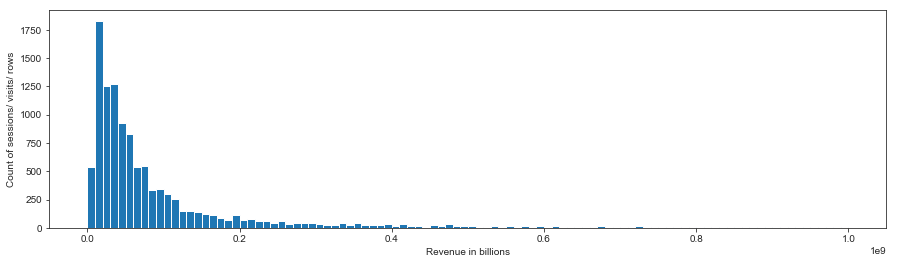

In [137]:
fig, ax = plt.subplots()
fig.set_size_inches(w=15,h=4)

ax.set_xlabel("Revenue in billions")
ax.set_ylabel("Count of sessions/ visits/ rows")

_ = ax.hist(non_zero_revenues,bins=100, range=(0,1e9))

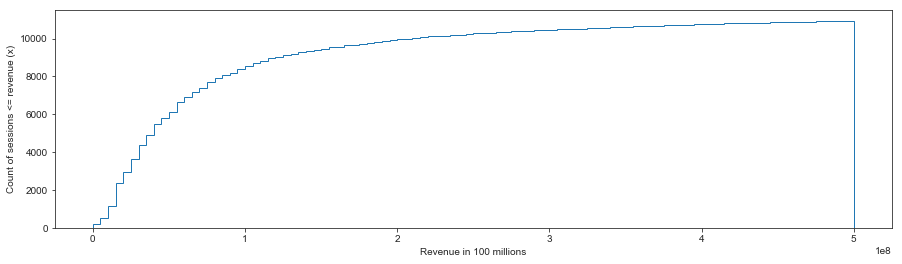

In [140]:
# cumulative distribution of the revenues
fig, ax = plt.subplots()
fig.set_size_inches(w=15,h=4)
ax.set_xlabel("Revenue in 100 millions")
ax.set_ylabel("Count of sessions <= revenue (x)")
_ = ax.hist(non_zero_revenues,bins=100,range=(0,0.5e9),cumulative=True,histtype='step')

In [139]:
# revenues details
print("Minimum revenue per session: ", non_zero_revenues.min())
print("Maximum revenue per session: ", non_zero_revenues.max())
print("\nQuantiles for revenue per session: ")
print(non_zero_revenues.quantile(q=[0,0.1,0.25,0.5,0.75,0.9,1]))

Minimum revenue per session:  10000.0
Maximum revenue per session:  23129500000.0

Quantiles for revenue per session: 
0.00    1.000000e+04
0.10    1.519000e+07
0.25    2.493000e+07
0.50    4.945000e+07
0.75    1.076550e+08
0.90    2.790540e+08
1.00    2.312950e+10
Name: totals.transactionRevenue, dtype: float64


In [9]:
# other info for all non zero transaction revenues
train_df.loc[revenue_index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 55 columns):
channelGrouping                                      11515 non-null object
date                                                 11515 non-null int64
fullVisitorId                                        11515 non-null object
sessionId                                            11515 non-null object
socialEngagementType                                 11515 non-null object
visitId                                              11515 non-null int64
visitNumber                                          11515 non-null int64
visitStartTime                                       11515 non-null int64
device.browser                                       11515 non-null object
device.browserSize                                   11515 non-null object
device.browserVersion                                11515 non-null object
device.deviceCategory                                11515 non-null

#### Proportion of unique visitorIds for revenue vs non-revenue sessions

In [145]:
# unique visitors with non zero revenue
unique_revenue_visits = train_df[train_df['totals.transactionRevenue'] > 0].fullVisitorId.unique().size

# with zero revenue
unique_zero_revenue_visits = train_df[train_df['totals.transactionRevenue'] == 0].fullVisitorId.unique().size

In [146]:
revenue_visits = train_df[train_df['totals.transactionRevenue'] > 0].size
zero_revenue_visits = train_df[train_df['totals.transactionRevenue'] == 0].size

In [154]:
print("Percentage of unique users for:")
print("\trevenue visits", unique_revenue_visits * 100 / revenue_visits)
print("\tnon revenue visits", unique_zero_revenue_visits * 100 / zero_revenue_visits)

Percentage of unique users for:
	revenue visits 1.5783365570599612
	non revenue visits 1.4488891751153867


#### general info about fields

In [155]:
train_df.describe()

,date,visitId,visitNumber,visitStartTime,totals.transactionRevenue
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,9.036530e+05
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,1.704273e+06
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,5.277866e+07
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,0.000000e+00
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,0.000000e+00
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,0.000000e+00
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,0.000000e+00
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,2.312950e+10


In [34]:
# unique channels
train_df.channelGrouping.unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

In [35]:
# date
train_df.date.unique()

array([20160902, 20170126, 20170623, 20170312, 20170203, 20160811,
       20170613, 20170113, 20161118, 20161110, 20161112, 20170621,
       20161123, 20170501, 20170611, 20170630, 20161213, 20170519,
       20170111, 20170624, 20161014, 20170529, 20170515, 20170420,
       20160831, 20170801, 20170228, 20161209, 20160917, 20170617,
       20161216, 20160820, 20170616, 20160822, 20161129, 20170318,
       20161130, 20170303, 20160816, 20161030, 20161230, 20170704,
       20170213, 20170511, 20160912, 20161022, 20160824, 20170421,
       20170412, 20160805, 20161018, 20170310, 20170428, 20170116,
       20170115, 20170102, 20170320, 20170410, 20161125, 20170311,
       20170622, 20170329, 20161026, 20170308, 20161124, 20161021,
       20170217, 20170627, 20161117, 20161109, 20160819, 20161128,
       20160901, 20161122, 20170615, 20170714, 20160915, 20170606,
       20161107, 20160929, 20160821, 20160803, 20170321, 20170128,
       20160906, 20170724, 20161208, 20170118, 20161020, 20170

#### Questions to ask:

- How is date associated with the revenues?
- Is there any trend/pattern with respect to date and revenue?
- There are 714167 unique visitor ids for the total of 903653 rows. What about the visitor ids of test set. Are the mutually exclusive than the train set ids?
- The revenues given are per user session?
- So is there a case where the same visitorId has revenue more than one time. Or in other words multiple rows for same visitorId have non-zero transaction revenue?

In [62]:
train_df.fullVisitorId

0         1131660440785968503
1          377306020877927890
2         3895546263509774583
3         4763447161404445595
4           27294437909732085
5         2938943183656635653
6         1905672039242460897
7          537222803633850821
8         4445454811831400414
9         9499785259412240342
10        0523069750702990437
11         982320996976275749
12         357659889600827884
13        1438082600262726746
14        3531015320757710684
15        9638207207743070032
16        9876750586615598787
17        2222266935962032743
18        9674781571160116268
19        3696906537737368442
20        4478318070775453050
21        6098154234696452861
22        3323434834508685818
23        3053576296023059465
24         702736826487255366
25        8794587387581803040
26        3293772317640873624
27        1283542838194038522
28        4339756682310369249
29        7598520899202646361
                 ...         
903623    6636384798982309878
903624    3949036270578731944
903625    

In [14]:
train_df[1:1000].groupby('fullVisitorId').apply(lambda x: list((x.index, x.totals.transactionRevenue)))

fullVisitorId
0005096736076850458         [820]
0015065858137292339         [719]
0018131669611141208         [980]
0019595737093157672         [951]
0042187268246961920         [125]
0057228682567989873         [938]
0063191589012692475         [562]
010089030391699708          [702]
0113895825226302532          [94]
0129431257283813068         [582]
0131151074734304934         [504]
0131179127719119947         [178]
0185467632009737931    [683, 802]
0222416580106802736         [824]
0233327970438842308         [177]
0235163185121505241         [831]
0239575343807682372          [45]
0259347581822527605         [416]
0279061735787069658         [258]
0280238535388529584         [130]
0291367698246091951         [772]
0314733033105141755         [976]
0324986642157335302         [302]
0326331894704342594         [232]
0334360546945417186         [532]
0369009073977683421         [179]
0372293367991472845         [346]
0376226808798391185         [896]
0377252082666908306         [273]


In [20]:
# checkout revenue for a customer visiting multiple times
train_df[train_df.fullVisitorId == '0185467632009737931']['totals.transactionRevenue']
# later on we will find out different columns for each customer with multiple visits

683            NaN
802       26250000
62021          NaN
62034          NaN
189461         NaN
392669         NaN
Name: totals.transactionRevenue, dtype: object

In [70]:
repeated_visitor_ids = (train_df.fullVisitorId.value_counts()>1).index
#repeated_visitors = train_df[train_df.fullVisitorId.isin()]

In [71]:
repeated_visitor_ids.size

714167

In [53]:
train_df.fullVisitorId.size

903653

In [156]:
# check out unique values for each column
can_be_deleted_columns = defaultdict()
other_colums = defaultdict()

def explore_uniques(col):
    print("\nChecking column: ", col)
    uniques = train_df[col].unique()
    len_uniques = len(uniques)
    print("Number of unique values is: ", len_uniques)
    if len_uniques < 50:
        print(uniques)
    if len_uniques ==1:
        can_be_deleted_columns.update({col: uniques})
    else:
        other_colums.update({col: len_uniques})

In [157]:
explore_uniques('device.browserSize')


Checking column:  device.browserSize
Number of unique values is:  1
['not available in demo dataset']


In [158]:
for col in list(train_df.columns):
    explore_uniques(col)


Checking column:  channelGrouping
Number of unique values is:  8
['Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct' 'Display'
 'Social' '(Other)']

Checking column:  date
Number of unique values is:  366

Checking column:  fullVisitorId
Number of unique values is:  714167

Checking column:  sessionId
Number of unique values is:  902755

Checking column:  socialEngagementType
Number of unique values is:  1
['Not Socially Engaged']

Checking column:  visitId
Number of unique values is:  886303

Checking column:  visitNumber
Number of unique values is:  384

Checking column:  visitStartTime
Number of unique values is:  887159

Checking column:  device.browser
Number of unique values is:  54

Checking column:  device.browserSize
Number of unique values is:  1
['not available in demo dataset']

Checking column:  device.browserVersion
Number of unique values is:  1
['not available in demo dataset']

Checking column:  device.deviceCategory
Number of unique values is:  3
['deskt

In [159]:
can_be_deleted_columns

defaultdict(None,
            {'device.browserSize': array(['not available in demo dataset'], dtype=object),
             'device.browserVersion': array(['not available in demo dataset'], dtype=object),
             'device.flashVersion': array(['not available in demo dataset'], dtype=object),
             'device.language': array(['not available in demo dataset'], dtype=object),
             'device.mobileDeviceBranding': array(['not available in demo dataset'], dtype=object),
             'device.mobileDeviceInfo': array(['not available in demo dataset'], dtype=object),
             'device.mobileDeviceMarketingName': array(['not available in demo dataset'], dtype=object),
             'device.mobileDeviceModel': array(['not available in demo dataset'], dtype=object),
             'device.mobileInputSelector': array(['not available in demo dataset'], dtype=object),
             'device.operatingSystemVersion': array(['not available in demo dataset'], dtype=object),
             'devi

In [160]:
# deleting the useless columns
for col in can_be_deleted_columns:
    train_df.drop(col,axis=1,inplace=True)

In [161]:
other_colums

defaultdict(None,
            {'channelGrouping': 8,
             'date': 366,
             'device.browser': 54,
             'device.deviceCategory': 3,
             'device.isMobile': 2,
             'device.operatingSystem': 20,
             'fullVisitorId': 714167,
             'geoNetwork.city': 649,
             'geoNetwork.continent': 6,
             'geoNetwork.country': 222,
             'geoNetwork.metro': 94,
             'geoNetwork.networkDomain': 28064,
             'geoNetwork.region': 376,
             'geoNetwork.subContinent': 23,
             'sessionId': 902755,
             'totals.bounces': 2,
             'totals.hits': 274,
             'totals.newVisits': 2,
             'totals.pageviews': 214,
             'totals.transactionRevenue': 5333,
             'trafficSource.adContent': 45,
             'trafficSource.adwordsClickInfo.adNetworkType': 3,
             'trafficSource.adwordsClickInfo.gclId': 17775,
             'trafficSource.adwordsClickInfo.isVideoA

In [162]:
sorted([(v,k) for (k,v) in other_colums.items()])

[(2, 'device.isMobile'),
 (2, 'totals.bounces'),
 (2, 'totals.newVisits'),
 (2, 'trafficSource.adwordsClickInfo.isVideoAd'),
 (2, 'trafficSource.campaignCode'),
 (2, 'trafficSource.isTrueDirect'),
 (3, 'device.deviceCategory'),
 (3, 'trafficSource.adwordsClickInfo.adNetworkType'),
 (3, 'trafficSource.adwordsClickInfo.slot'),
 (6, 'geoNetwork.continent'),
 (7, 'trafficSource.medium'),
 (8, 'channelGrouping'),
 (9, 'trafficSource.adwordsClickInfo.page'),
 (10, 'trafficSource.campaign'),
 (20, 'device.operatingSystem'),
 (23, 'geoNetwork.subContinent'),
 (45, 'trafficSource.adContent'),
 (54, 'device.browser'),
 (94, 'geoNetwork.metro'),
 (214, 'totals.pageviews'),
 (222, 'geoNetwork.country'),
 (274, 'totals.hits'),
 (366, 'date'),
 (376, 'geoNetwork.region'),
 (380, 'trafficSource.source'),
 (384, 'visitNumber'),
 (649, 'geoNetwork.city'),
 (1476, 'trafficSource.referralPath'),
 (3660, 'trafficSource.keyword'),
 (5333, 'totals.transactionRevenue'),
 (17775, 'trafficSource.adwordsClickIn

In [171]:
# function to draw various bar plots
def draw_bar_plot(x,height,xlabel,ylabel,fig_w=5,fig_h=5,title=None,xticklabels=None,xticks=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(w=fig_w,h=fig_h)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:      
        ax.set_ylabel(ylabel)
    if xticklabels:    
        ax.set_xticklabels(xticklabels)
    else:
        ax.set_xticklabels(x)
    if xticks:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(x)))
    if title:
        ax.set_title(title)
    
    return ax.bar(x,height,color=sns.color_palette(n_colors=len(x)))

In [172]:
# Let us plot various revenues for various groups
avg_rev_mobile = train_df.groupby('device.isMobile')['totals.transactionRevenue'].mean()

In [173]:
avg_rev_mobile, avg_rev_mobile.index, avg_rev_mobile.values

(device.isMobile
 False    2.228389e+06
 True     2.477370e+05
 Name: totals.transactionRevenue, dtype: float64,
 Index([False, True], dtype='object', name='device.isMobile'),
 array([2228389.43313319,  247736.98054976]))

<Container object of 2 artists>

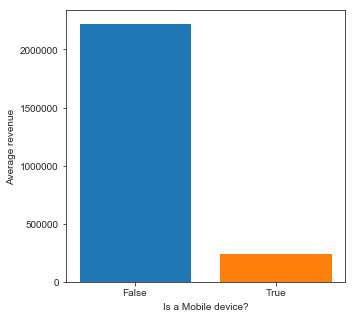

In [174]:
draw_bar_plot(x=avg_rev_mobile.index.values,height=avg_rev_mobile.values,xlabel="Is a Mobile device?" \
              ,ylabel="Average revenue")

In [182]:
# change boolean variables into 1/0 number
    

In [184]:
# convert bounces
boolean_to_one_zero('totals.bounces',1,True)

In [188]:
avg_rev_bounces = train_df.groupby('totals.bounces')['totals.transactionRevenue'].mean()

<Container object of 2 artists>

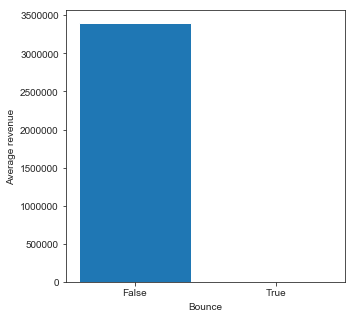

In [189]:
draw_bar_plot(x=avg_rev_bounces.index.values,height=avg_rev_bounces.values,xlabel="Bounce" \
              ,ylabel="Average revenue",xticklabels=['False','True'])

In [190]:
# convert new visits
boolean_to_one_zero('totals.newVisits','1',True)

In [196]:
train_df['totals.newVisits'].describe()

count    903653.000000
mean          0.872334
std           0.333718
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: totals.newVisits, dtype: float64

<Container object of 2 artists>

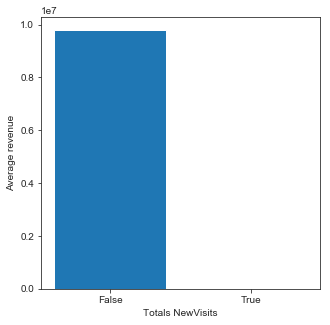

In [197]:
avg_rev_newVisits = train_df.groupby('totals.newVisits')['totals.transactionRevenue'].mean()

draw_bar_plot(x=avg_rev_newVisits.index.values,height=avg_rev_newVisits.values,xlabel="Totals NewVisits" \
              ,ylabel="Average revenue",xticklabels=['False','True'])

In [193]:
# convert trafficSource.adwordsClickInfo.isVideoAd
boolean_to_one_zero('trafficSource.adwordsClickInfo.isVideoAd',False,False)

In [194]:
train_df['trafficSource.adwordsClickInfo.isVideoAd'].describe()

count    903653.000000
mean          0.995467
std           0.067173
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: trafficSource.adwordsClickInfo.isVideoAd, dtype: float64

<Container object of 2 artists>

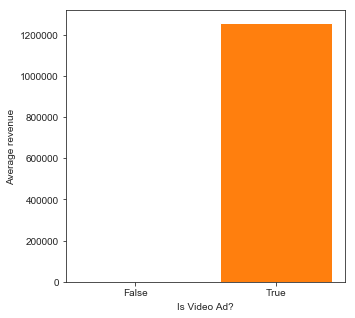

In [195]:
avg_rev_isVideoAd = train_df.groupby('trafficSource.adwordsClickInfo.isVideoAd')['totals.transactionRevenue'].mean()

draw_bar_plot(x=avg_rev_isVideoAd.index.values,height=avg_rev_isVideoAd.values,xlabel="Is Video Ad?" \
              ,ylabel="Average revenue",xticklabels=['False','True'])

In [198]:
# convert campaign code
boolean_to_one_zero('trafficSource.campaignCode','11251kjhkvahf',True)

In [199]:
train_df['trafficSource.campaignCode'].describe()

count    903653.000000
mean          0.872334
std           0.333718
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: trafficSource.campaignCode, dtype: float64

<Container object of 2 artists>

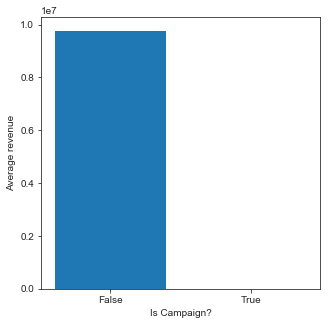

In [200]:
avg_rev_campaign = train_df.groupby('trafficSource.campaignCode')['totals.transactionRevenue'].mean()

draw_bar_plot(x=avg_rev_campaign.index.values,height=avg_rev_campaign.values,xlabel="Is Campaign?" \
              ,ylabel="Average revenue",xticklabels=['False','True'])

In [201]:
# convert is trueDirect
boolean_to_one_zero('trafficSource.isTrueDirect',True,True)

In [202]:
train_df['trafficSource.isTrueDirect'].describe()

count    903653.000000
mean          0.974318
std           0.158186
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: trafficSource.isTrueDirect, dtype: float64

<Container object of 2 artists>

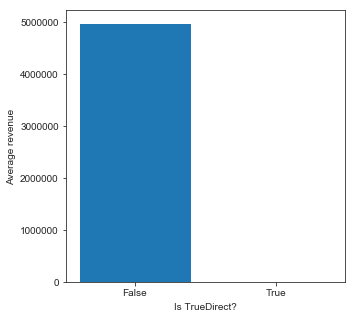

In [203]:
avg_rev_trueDirect = train_df.groupby('trafficSource.isTrueDirect')['totals.transactionRevenue'].mean()

draw_bar_plot(x=avg_rev_trueDirect.index.values,height=avg_rev_trueDirect.values,xlabel="Is TrueDirect?" \
              ,ylabel="Average revenue",xticklabels=['False','True'])

#### Explore columns with more than 2 unique values

<Container object of 3 artists>

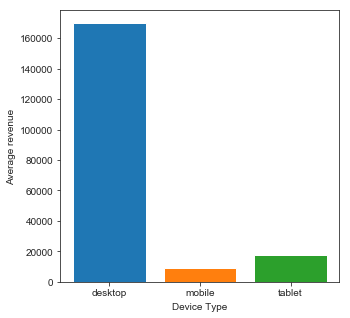

In [209]:
# device category
train_df['device.deviceCategory'] = original_train_df['device.deviceCategory']

avg_rev_device_cat = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].mean()

draw_bar_plot(x=avg_rev_device_cat.index.values,height=avg_rev_device_cat.values,xlabel="Device Type" \
              ,ylabel="Average revenue")

In [222]:
# trafficSource.adwordsClickInfo.adNetworkType
train_df['trafficSource.adwordsClickInfo.adNetworkType'] = original_train_df['trafficSource.adwordsClickInfo.adNetworkType']
#train_df['trafficSource.adwordsClickInfo.adNetworkType'].fillna("NA",inplace=True)
avg_rev_network_type = train_df.groupby('trafficSource.adwordsClickInfo.adNetworkType')['totals.transactionRevenue'].mean()

<Container object of 2 artists>

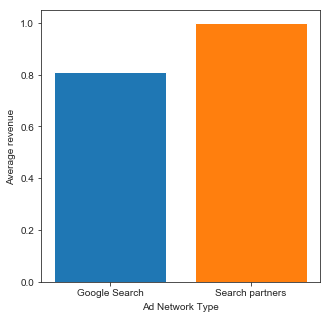

In [223]:
draw_bar_plot(x=avg_rev_network_type.index.values,height=avg_rev_network_type,xlabel="Ad Network Type" \
              ,ylabel="Average revenue")

In [234]:
train_df['trafficSource.adwordsClickInfo.adNetworkType'].unique()

array([nan, 'Google Search', 'Search partners'], dtype=object)

In [236]:
# avg revenue very high when no ad network type
train_df[train_df['trafficSource.adwordsClickInfo.adNetworkType'].isnull()]['totals.transactionRevenue'].mean()

130938.63030085253

<Container object of 2 artists>

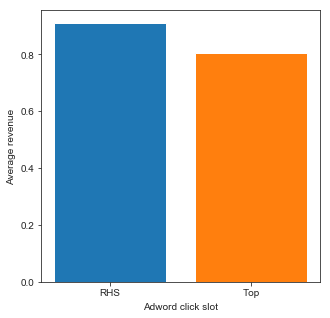

In [239]:
# trafficSource.adwordsClickInfo.slot
train_df['trafficSource.adwordsClickInfo.slot'] = original_train_df['trafficSource.adwordsClickInfo.slot']
avg_rev_slot = train_df.groupby('trafficSource.adwordsClickInfo.slot')['totals.transactionRevenue'].mean()
draw_bar_plot(x=avg_rev_slot.index.values,height=avg_rev_slot,xlabel="Adword click slot" \
              ,ylabel="Average revenue")


In [240]:
# avg revenue very high when no slot
train_df[train_df['trafficSource.adwordsClickInfo.slot'].isnull()]['totals.transactionRevenue'].mean()

130938.63030085253

In [241]:
train_df['geoNetwork.continent'].unique()

array([1, 0, 'Americas', 'Europe', 'Asia', 'Oceania', 'Africa',
       '(not set)'], dtype=object)

In [192]:
# find unique browser sizes
train_df['device.browserSize'].unique().size

1

In [194]:
# we can remove it because it doesn't server any purpose
train_df.drop('device.browserSize',inplace=True,axis=1)

In [195]:
train_df.socialEngagementType.unique().size

1

In [196]:
train_df.drop('socialEngagementType',inplace=True,axis=1)

In [197]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.deviceCategory,...,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,day,zero_revenue
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,not available in demo dataset,desktop,...,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,32,0
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,not available in demo dataset,desktop,...,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,32,0
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,not available in demo dataset,desktop,...,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,32,0
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,not available in demo dataset,desktop,...,NaN,(not set),NaN,NaN,google + online,organic,NaN,google,32,0
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,not available in demo dataset,mobile,...,NaN,(not set),NaN,True,(not provided),organic,NaN,google,32,0
